In [1]:
# ideas for a source test
import cobra
import pandas as pd
from typing import Literal
import warnings

import refinegems as rg


# @TODO : set a default for substances - ideally a subset or so
# @TODO : more namespace options, currently only BiGG available
# @TEST
def test_growth_with_source(model:cobra.Model, element:str, substances:None|str|list[str], medium:None|str|rg.medium.Medium=None, namespace:Literal['BiGG']='BiGG') -> rg.reports.SourceTestReport:
    
    # validate input
    # model is required to have a growth function
    growth_funcs = rg.biomass.test_biomass_presence(model)
    if growth_funcs:
        if model.objective in growth_funcs:
            pass
        else:
            warnings.warn(f'No growth functions set as objective, but growth function detected. Setting objective to {growth_funcs[0]}')
            model.objective = growth_funcs[0]
    else:
        raise KeyError('No growth function in model. Please add one beforehand.')
    
    # get the starting medium
    match medium:
        case str():
            current_medium = rg.medium.load_medium_from_db(medium)
        case rg.medium.Medium():
            current_medium = medium
        case _:
            current_medium = rg.medium.read_from_cobra_model(model)

    # save old medium settings
    origin_medium = model.medium

    # get the sources
    match substances:

        # case 1: 
        # take a given subset from the database
        case str():
            temp_medium = rg.medium.Medium('temp', pd.DataFrame(columns=['name','formula','flux','source','db_id','db_type']))
            temp_medium.add_subset(substances)
            source_list = temp_medium.substance_table['name'].to_list()

        # case 2: 
        # use the user given list - account for errors
        case list():
            # @TODO validate, if all are part of the database or is this over the top?
            source_list = substances

        # case 3:
        # download all possible options - may take some time
        case _:
            # get complete table
            substances = rg.io.load_a_table_from_database('substance', query=False)
            # regex to find substances with element - element letter code NOT followed by ANY small letter
            element_regex = element + r'(?![a-z])' 
            substances_mask = substances['formula'].str.contains(element_regex)
            substances_mask.fillna(value=False, inplace=True)
            substances = substances[substances_mask]
            source_list = substances.name.to_list()

    # perform the test
    results = []  
    for s in source_list:
        # set new source
        current_medium.set_source(element,s)
        # add medium to model
        rg.medium.medium_to_model(model, current_medium, namespace=namespace, add=True)
        # simulate growth
        growth_value = model.optimize().objective_value
        results.append({'substance':s, 'growth value':growth_value})

    results = rg.reports.SourceTestReport(pd.DataFrame(results), element, model.id)

    # set original medium for model
    model.medium = origin_medium

    return results
        


/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [32]:
test_model_path = '/Users/brune/Downloads/iML1515.xml'
test_model = rg.io.load_model_cobra(test_model_path)
e = 'N'
substances = None
medium = None

source_res = test_growth_with_source(test_model, e, substances, medium)


/var/folders/xd/zl0vk7sj60xcc0zmc4k4mxxc0000gr/T/ipykernel_10284/2186973756.py:22: UserWarning: No growth functions set as objective, but growth function detected. Setting objective to BIOMASS_Ec_iML1515_WT_75p37M
  warnings.warn(f'No growth functions set as objective, but growth function detected. Setting objective to {growth_funcs[0]}')


In [33]:
source_res.results

,substance,growth value
0,1-Methylnicotinamide,-9.631440e-16
1,1-Methyl-4-imidazoleacetic acid,1.750406e-16
2,"2,2-Bipyridine",1.750406e-16
3,"2,3-Cyclic GMP [Cyclic GMP]",0.000000e+00
4,"3,5-Cyclic GMP [Cyclic GMP]",0.000000e+00
...,...,...
140,Uridine,0.000000e+00
141,Xanthurenic acid,0.000000e+00
142,beta-Alanine,0.000000e+00
143,trans-4-Hydroxy-L-proline,0.000000e+00


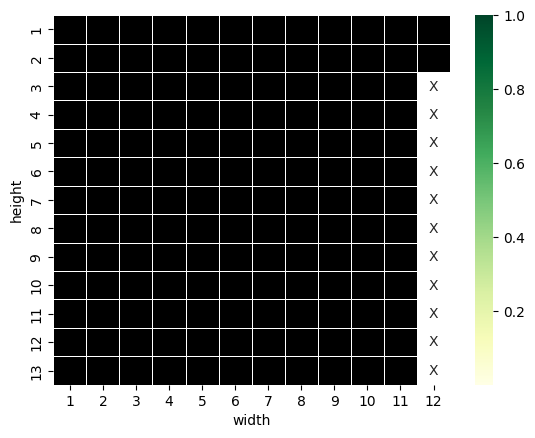

In [55]:
import math
import copy
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from itertools import chain

# params
width = 12
color_palette = 'YlGn'

# function

# create colour gradient
try:
    cmap = matplotlib.colormaps[color_palette]
except ValueError:
    warnings.warn('Unknown color palette, setting it to "YlGn"')
    cmap = matplotlib.colormaps['YlGn']

cmap.set_under('black') # too low / no growth
cmap.set_over('white') # no data

# get size of heatmap
height = math.ceil(len(source_res.results)/width)
total_cells = width * height
# create table for plotting
data_to_plot = copy.deepcopy(source_res.results)
if len(source_res.results) < total_cells:
    temp = pd.DataFrame.from_records([['empty',None]]*(total_cells-len(source_res.results)),columns=['substance','growth value'])
    data_to_plot = pd.concat([data_to_plot, temp], ignore_index=True)
data_to_plot['height'] = list(range(1,height+1))*width
data_to_plot['width'] = list(chain.from_iterable([[x]*height for x in range(1,width+1)]))
# remove unplottable entries 
data_to_plot['growth value'].replace([np.inf, -np.inf], 0, inplace=True)
over_growth = data_to_plot['growth value'].max() + 2
data_to_plot['growth value'].replace(np.nan, over_growth, inplace=True)
vmin= 1e-5 #Use same threshhold as in find_missing_essential in growth
vmax=over_growth - 1
# set annotations
annot = data_to_plot.copy().pivot(index='height',columns='width', values='growth value')
annot = annot.round(2)
annot[annot < 1e-5] = ''
annot.replace(over_growth.round().astype(int), 'X', inplace=True)

# plot
hm = sn.heatmap(data_to_plot.pivot(index='height',columns='width', values='growth value'),
                linewidth=.5, cmap=cmap,
                vmin=vmin, vmax=vmax,
                annot=annot, fmt=''
                )
plt.show()



In [22]:
list(range(1,13))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]